In [73]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import platform

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e8:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F76727%2F9045607%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240824%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240824T215415Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3e21a1fc93e05efdd93a76c3ea5d164d2aee454ea2475514497308f4fb0f4e0fdb899a1c7eb9ea9cb0551657c617d14f7abe5e459b24e7103d880c1a010579e03481b3d95139ac187afb68697242c03431908861e00bb02cb9c4e63c254ca3a85efb168ecfd3329e1359449a8a5c86d71f41d2e1287e6665eee21d306f8275ebe9338f0a026b276dbbed1782b142f6c865efdbb29f469ca3abe3ee3302a9e5869c1b28ddeb1cd41478769e392dad15865789f37e4a071a096c2ef6d1709391b621687db383bc9845e37a109a8915c36d213289dc4b7f6d2f6a3db5e3ee1d36f2a59a6b9865db862e6e0b1c4b258aa18be02fb191413ee16381b4a060f39a5ead,mushroom-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F478%2F974%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240824%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240824T215415Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8c7263c0910736e34c22d9d13202af556945b937661f29e1259a91e6111516318d23a82ce83bf577beff2624336a281226c2f2162b5938b902bb49f4eeb7a1219d0cc0f372201c2b5559037256aa356d16432840b3e56b810501910a1fa0be98c8582ebba48e197e2e5b6354a818e4bcccbcf834176cd391dcea501aa6af9526f90feb49440996b09a404f5eaeb9fd4623e84e9f37c31bc219d133065c11a98fb99ff7a6967d050551d2c42b162f7f8a64936770922569b857290859fdf46677dfd9077ca2dd7ccda1f8f78645460895f90a61e6e3de27b4fec972df9ac8df5db85512d7e7772edd4a3eb1efe652836007dceb9b72e4d729e526549861ad69ae'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'

os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# Solo crear symlinks si no estás en Windows
if platform.system() != 'Windows':
    try:
        os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
    except FileExistsError:
        pass
    try:
        os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
    except FileExistsError:
        pass


for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 86301661 bytes downloaded
Downloaded and uncompressed: playground-series-s4e8
[==================================================] 35057 bytes downloaded
Downloaded and uncompressed: mushroom-classification
Data source import complete.


<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">Importing Libraries</h1>  
     
</div>

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgb
import gc

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">🎇🌭Loading  Dataset ♒🌊</h1>  
     
</div>

In [75]:
df_sub=pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")
df_train=pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
df_test=pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")

<p style="font-family: 'Amiri', serif; font-size: 3rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: grey; padding: 10px; border-radius: 10px; border: 7px solid cyan; width: 95%;">
  <span style="font-weight: bold; color: blue; animation: pulse 2s infinite;">📉Check </span>
  <span style="font-style: italic; color: #2ca02c; animation: pulse 2s infinite;"> on Data  📊</span>
</p>

In [76]:
df_train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [77]:
df_test.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.47,x,t,n,f,s,c,n,4.98,...,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,...,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


In [78]:
df_test.shape,df_train.shape

((2077964, 21), (3116945, 22))

In [79]:
df_train = df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: white; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>Data Talks :</font></h3>
    
**Intial Drop** : Drop Column ID....🎃
    
**Train & Test Distribution** : Looks Heavy no of rows 🎆    
    
**About Feature Columns** : We have 21 and 22 columns in which we can see, lots of features have missing value 🎭

<p style="font-family: 'Amiri', serif; font-size: 3rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: grey; padding: 10px; border-radius: 10px; border: 7px solid cyan; width: 95%;">
  <span style="font-weight: bold; color: blue; animation: pulse 2s infinite;">📉Checking  </span>
  <span style="font-style: italic; color: #2ca02c; animation: pulse 2s infinite;"> Distribution of categorical features  📊</span>
</p>

In [80]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 499.4+ MB


In [81]:
categorical_columns = df_train.select_dtypes(include=['object']).columns
unique_values = {col: df_train[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")

gc.collect()

class: 2 unique values
cap-shape: 74 unique values
cap-surface: 83 unique values
cap-color: 78 unique values
does-bruise-or-bleed: 26 unique values
gill-attachment: 78 unique values
gill-spacing: 48 unique values
gill-color: 63 unique values
stem-root: 38 unique values
stem-surface: 60 unique values
stem-color: 59 unique values
veil-type: 22 unique values
veil-color: 24 unique values
has-ring: 23 unique values
ring-type: 40 unique values
spore-print-color: 32 unique values
habitat: 52 unique values
season: 4 unique values


1238

In [82]:
categorical_columns = df_test.select_dtypes(include=['object']).columns
unique_values = {col: df_test[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")

gc.collect()

cap-shape: 62 unique values
cap-surface: 59 unique values
cap-color: 57 unique values
does-bruise-or-bleed: 22 unique values
gill-attachment: 66 unique values
gill-spacing: 35 unique values
gill-color: 56 unique values
stem-root: 31 unique values
stem-surface: 54 unique values
stem-color: 55 unique values
veil-type: 15 unique values
veil-color: 23 unique values
has-ring: 23 unique values
ring-type: 36 unique values
spore-print-color: 33 unique values
habitat: 39 unique values
season: 4 unique values


0

In [83]:
df_test.columns

Index(['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [84]:
df_train.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

<p style="font-family: 'Amiri', serif; font-size: 3rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: black; padding: 20px; border-radius: 20px; border: 7px solid cyan; width: 95%;">
  <span style="font-weight: bold; color: blue; animation: pulse 2s infinite;">📉Exploratory</span>
  <span style="font-style: italic; color: #2ca02c; animation: pulse 2s infinite;"> Data Analysis(EDA)  📊</span>
</p>

In [85]:
import seaborn as sns

In [86]:
missing_train = df_train.isna().mean() * 100
missing_test = df_test.isna().mean() * 100

print("Columns in df_train with more than 10% missing values:")
print(missing_train[missing_train > 0])

print("\nColumns in df_test with more than 10% missing values:")
print(missing_test[missing_test > 0])

Columns in df_train with more than 10% missing values:
cap-diameter             0.000128
cap-shape                0.001283
cap-surface             21.528227
cap-color                0.000385
does-bruise-or-bleed     0.000257
gill-attachment         16.809280
gill-spacing            40.373988
gill-color               0.001829
stem-root               88.452732
stem-surface            63.551362
stem-color               0.001219
veil-type               94.884350
veil-color              87.936970
has-ring                 0.000770
ring-type                4.134818
spore-print-color       91.425482
habitat                  0.001444
dtype: float64

Columns in df_test with more than 10% missing values:
cap-diameter             0.000337
cap-shape                0.001492
cap-surface             21.506821
cap-color                0.000626
does-bruise-or-bleed     0.000481
gill-attachment         16.834796
gill-spacing            40.404694
gill-color               0.002358
stem-height              

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: white; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>Data Talks :</font></h3>
    
**Common Columns:** Both df_train and df_test share the same columns with more than 10% missing values.
    
**High Missing Values:** The columns stem-root, veil-type, veil-color, and spore-print-color have a very high percentage of missing values, exceeding 80% in both datasets..🎃
    
**Moderate Missing Values:** The columns cap-surface, gill-attachment, gill-spacing, and stem-surface have moderate missing values, ranging from approximately 16% to 63%. 🎭

C:\Users\andre\AppData\Local\Temp\ipykernel_19824\3726948150.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




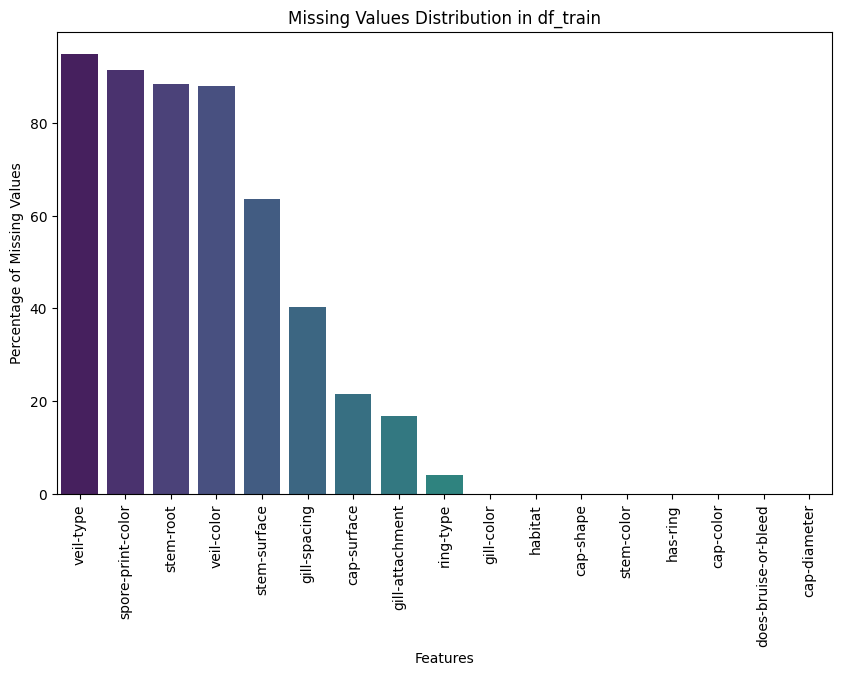

In [87]:
missing_values = df_train.isnull().mean() * 100
missing_values = missing_values[missing_values >0]
missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Distribution in df_train')
plt.show()

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import category_encoders as ce

missing_threshold = 0.95

high_missing_columns = df_train.columns[df_train.isnull().mean() > missing_threshold]

df_train = df_train.drop(columns=high_missing_columns)
df_test = df_test.drop(columns=high_missing_columns)
target = 'class'

for column in df_train.columns:
    if df_train[column].isnull().any():
        if df_train[column].dtype == 'object':
            mode_value = df_train[column].mode()[0]
            df_train[column].fillna(mode_value, inplace=True)
            df_test[column].fillna(mode_value, inplace=True)
        else:
            median_value = df_train[column].median()
            df_train[column].fillna(median_value, inplace=True)
            df_test[column].fillna(median_value, inplace=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_19824\3800662110.py:21: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\andre\AppData\Local\Temp\ipykernel_19824\3800662110.py:22: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

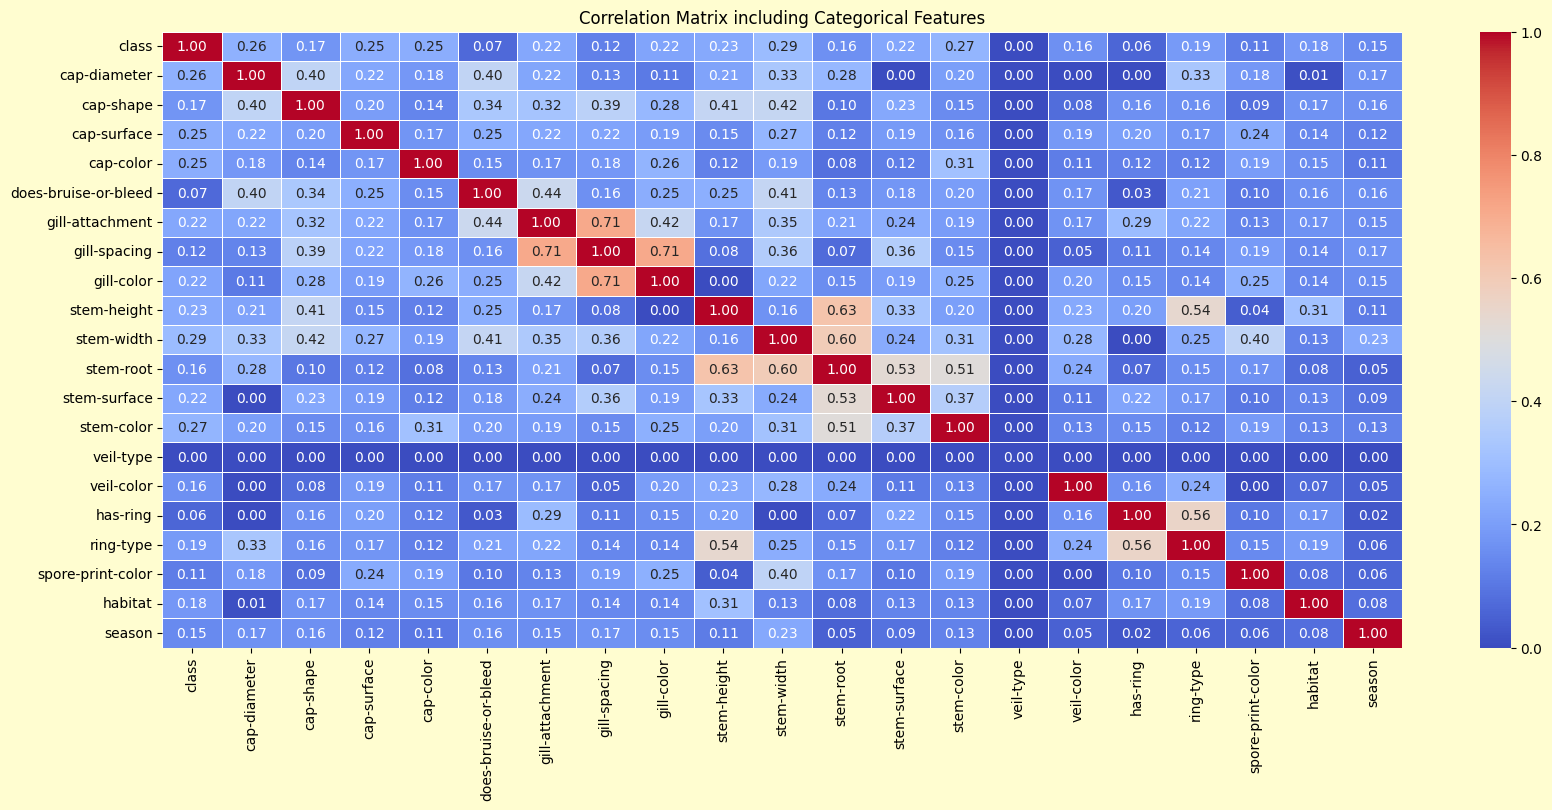

In [89]:
from dython.nominal import associations

associations_df = associations(df_train[:10000], nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0')
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

In [90]:
import plotly.io as pio

pio.renderers.default = "browser"

fig = px.sunburst(feature_counts, path=['cap-shape', 'cap-color'], values='count',
                  color='count', color_continuous_scale='Viridis',
                  title='Sunburst Chart of Cap Shape and Cap Color Distribution')

fig.update_layout(title_text='Sunburst Chart of Cap Shape and Cap Color Distribution',
                  title_x=0.5, width=900, height=600)
fig.show()


In [91]:
import plotly.graph_objects as go

flow_data = df_train1.groupby(['cap-shape', 'cap-color']).size().reset_index(name='count')
labels = list(pd.concat([flow_data['cap-shape'], flow_data['cap-color']]).unique())
label_map = {label: idx for idx, label in enumerate(labels)}

sources = flow_data['cap-shape'].map(label_map).tolist()
targets = flow_data['cap-color'].map(label_map).tolist()
values = flow_data['count'].tolist()


fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(
    title_text='Sankey Chart of Cap Shape to Cap Color Flow',
    title_x=0.5,
    width=1000,
    height=600
)
fig.show()

In [92]:
feature_counts = df_train1.groupby(['cap-shape', 'cap-color']).size().reset_index(name='count')
fig = px.bar(feature_counts, x='cap-shape', y='count', color='cap-color',
             title='Crosstab Chart of Cap Shape and Cap Color',
             labels={'cap-shape': 'Cap Shape', 'count': 'Count', 'cap-color': 'Cap Color'},
             color_discrete_sequence=px.colors.qualitative.Plotly,
             text='count')
fig.update_layout(
    title_text='Crosstab Chart of Cap Shape and Cap Color',
    title_x=0.5,
    xaxis_title='Cap Shape',
    yaxis_title='Count',
    barmode='stack'
)

fig.show()

In [93]:
cols_to_drop_train = missing_train[missing_train > 95].index
cols_to_drop_test = missing_test[missing_test > 95].index

df_train = df_train.drop(columns=cols_to_drop_train)
df_test = df_test.drop(columns=cols_to_drop_test)
gc.collect()

2338

![encoders.png](encoders.png)

In [94]:
from sklearn.impute import KNNImputer
import pandas as pd

def knn_impute(df, n_neighbors=5):
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed

In [95]:
df_train_imputed = knn_impute(df_train, n_neighbors=5)
df_test_imputed = knn_impute(df_test, n_neighbors=5)

In [96]:
cat_cols_train = df_train_imputed.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df_train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(df_train_imputed[cat_cols_train].astype(str))
df_test_imputed[cat_cols_train] = ordinal_encoder.transform(df_test_imputed[cat_cols_train].astype(str))

In [97]:
df_train_imputed.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,53.0,72.0,72.0,8.0,44.0,28.0,59.0,4.51,...,15.0,51.0,55.0,19.0,21.0,5.0,18.0,17.0,25.0,0.0
1,p,4.51,71.0,56.0,64.0,8.0,44.0,28.0,46.0,4.79,...,15.0,58.0,47.0,19.0,21.0,18.0,39.0,17.0,25.0,3.0
2,e,6.94,53.0,72.0,49.0,8.0,75.0,28.0,59.0,6.85,...,15.0,51.0,46.0,19.0,21.0,5.0,18.0,17.0,36.0,3.0
3,e,3.88,53.0,81.0,57.0,8.0,70.0,28.0,37.0,4.16,...,15.0,51.0,55.0,19.0,21.0,5.0,18.0,17.0,25.0,2.0
4,e,5.85,71.0,65.0,74.0,8.0,47.0,28.0,59.0,3.37,...,15.0,51.0,55.0,19.0,21.0,5.0,18.0,17.0,29.0,0.0


In [98]:
df_test_imputed.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,71.0,76.0,63.0,20.0,44.0,28.0,59.0,11.13,17.12,15.0,51.0,55.0,19.0,21.0,18.0,19.0,17.0,25.0,0.0
1,6.90,63.0,76.0,64.0,8.0,44.0,28.0,61.0,1.27,10.75,15.0,51.0,46.0,19.0,21.0,5.0,18.0,17.0,25.0,0.0
2,2.00,48.0,55.0,63.0,8.0,44.0,28.0,46.0,6.18,3.14,15.0,51.0,46.0,19.0,21.0,5.0,18.0,17.0,25.0,1.0
3,3.47,71.0,76.0,63.0,8.0,70.0,28.0,46.0,4.98,8.51,15.0,51.0,55.0,19.0,14.0,18.0,39.0,17.0,25.0,2.0
4,6.17,71.0,56.0,76.0,8.0,66.0,28.0,61.0,6.73,13.70,15.0,51.0,57.0,19.0,22.0,18.0,18.0,17.0,25.0,2.0


In [99]:
df_train = df_train_imputed
df_test = df_test_imputed

In [100]:
df_test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,71.0,76.0,63.0,20.0,44.0,28.0,59.0,11.13,17.12,15.0,51.0,55.0,19.0,21.0,18.0,19.0,17.0,25.0,0.0
1,6.90,63.0,76.0,64.0,8.0,44.0,28.0,61.0,1.27,10.75,15.0,51.0,46.0,19.0,21.0,5.0,18.0,17.0,25.0,0.0
2,2.00,48.0,55.0,63.0,8.0,44.0,28.0,46.0,6.18,3.14,15.0,51.0,46.0,19.0,21.0,5.0,18.0,17.0,25.0,1.0
3,3.47,71.0,76.0,63.0,8.0,70.0,28.0,46.0,4.98,8.51,15.0,51.0,55.0,19.0,14.0,18.0,39.0,17.0,25.0,2.0
4,6.17,71.0,56.0,76.0,8.0,66.0,28.0,61.0,6.73,13.70,15.0,51.0,57.0,19.0,22.0,18.0,18.0,17.0,25.0,2.0


In [101]:
le = LabelEncoder()
df_train['class'] = le.fit_transform(df_train['class'])

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 Observation from above plot :</font></h3>
    


In [102]:
y = df_train['class']
X = df_train.drop(['class'],axis=1)

<p style="font-family: 'Amiri', serif; font-size: 3rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: cyan; padding: 20px; border-radius: 20px; border: 7px solid #2ca02c; width: 95%;">
  <span style="font-weight: bold; color: #ff7f0e; animation: pulse 2s infinite;"></span>Model Building |
  <span style="font-style: italic; color: #2ca02c; animation: pulse 2s infinite;"> Training |</span> Classification

</p>

In [103]:
train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = 0.2, random_state =42,stratify=y)

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">🎇🌭Classification Analysis♒🌊</h1>  
     
</div>

In [104]:
from sklearn.metrics import matthews_corrcoef

In [105]:
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int)
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [106]:
from sklearn.metrics import matthews_corrcoef
from xgboost import XGBClassifier

model = XGBClassifier(
    alpha=0.1,
    subsample=0.8,
    colsample_bytree=0.6,
    objective='binary:logistic',
    max_depth=14,
    min_child_weight=7,
    gamma=1e-6,
    #random_state=42,
    n_estimators=100
    )

XGB = model.fit(
    train_X,
    train_y,
    eval_set=[(test_X, test_y)],
    verbose=False
    )

In [107]:
y_pred = XGB.predict(test_X)

In [108]:
!pip install lime

In [109]:
import lime
import lime.lime_tabular

In [110]:
redict_fn_xgb = lambda x: XGB.predict_proba(x).astype(float)
X = train_X.values
explainer = lime.lime_tabular.LimeTabularExplainer(X,feature_names = train_X.columns,class_names=['Poisnous','edible'],kernel_width=5)

In [111]:
df_test.head(4)

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.64,71.0,76.0,63.0,20.0,44.0,28.0,59.0,11.13,17.12,15.0,51.0,55.0,19.0,21.0,18.0,19.0,17.0,25.0,0.0
1,6.90,63.0,76.0,64.0,8.0,44.0,28.0,61.0,1.27,10.75,15.0,51.0,46.0,19.0,21.0,5.0,18.0,17.0,25.0,0.0
2,2.00,48.0,55.0,63.0,8.0,44.0,28.0,46.0,6.18,3.14,15.0,51.0,46.0,19.0,21.0,5.0,18.0,17.0,25.0,1.0
3,3.47,71.0,76.0,63.0,8.0,70.0,28.0,46.0,4.98,8.51,15.0,51.0,55.0,19.0,14.0,18.0,39.0,17.0,25.0,2.0


In [112]:
df_test.loc[[3]]

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
3,3.47,71.0,76.0,63.0,8.0,70.0,28.0,46.0,4.98,8.51,15.0,51.0,55.0,19.0,14.0,18.0,39.0,17.0,25.0,2.0


In [113]:
test_X

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
1745452,4.00,53.0,76.0,63.0,8.0,44.0,31.0,61.0,7.55,7.06,15.0,44.0,47.0,19.0,21.0,5.0,18.0,17.0,25.0,1.0
288331,9.30,63.0,76.0,63.0,8.0,44.0,28.0,59.0,5.00,26.53,15.0,51.0,46.0,19.0,21.0,5.0,18.0,17.0,25.0,2.0
421615,8.74,53.0,76.0,74.0,8.0,47.0,28.0,61.0,2.72,18.36,15.0,51.0,55.0,19.0,21.0,5.0,18.0,17.0,25.0,3.0
2794259,3.75,67.0,47.0,57.0,20.0,47.0,28.0,48.0,4.27,5.97,15.0,51.0,38.0,19.0,21.0,5.0,18.0,17.0,25.0,2.0
78948,15.30,67.0,76.0,60.0,8.0,44.0,31.0,61.0,4.83,22.90,15.0,51.0,55.0,19.0,21.0,5.0,18.0,29.0,25.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584520,5.57,48.0,56.0,60.0,8.0,70.0,31.0,59.0,5.56,11.97,15.0,51.0,38.0,19.0,21.0,5.0,18.0,17.0,25.0,0.0
2921070,5.62,53.0,81.0,63.0,8.0,70.0,28.0,37.0,5.08,8.44,15.0,51.0,55.0,19.0,21.0,5.0,18.0,17.0,25.0,0.0
2053944,6.23,53.0,81.0,63.0,8.0,52.0,28.0,48.0,3.63,11.73,15.0,51.0,55.0,19.0,21.0,18.0,23.0,17.0,48.0,0.0
44159,7.30,71.0,76.0,57.0,20.0,66.0,28.0,59.0,11.47,26.34,15.0,58.0,55.0,19.0,21.0,5.0,18.0,17.0,25.0,2.0


In [114]:
score = matthews_corrcoef(test_y, y_pred)
print('MCC:', score)

MCC: 0.9828627766861813


In [115]:
test_pred_prob = XGB.predict(df_test)

In [116]:
test_pred_prob

array([0, 1, 1, ..., 1, 0, 0])

In [117]:
#test_pred_binary = (test_pred_prob > 0.5).astype(int)
test_pred_class = le.inverse_transform(test_pred_prob)

In [118]:
df_sub['class']= test_pred_class

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">🗞📜Final Submission♒🌊</h1>  
     
</div>

In [119]:
#df_sub.to_csv('submission.csv', index = False)
#pd.read_csv('submission.csv')

<Axes: >

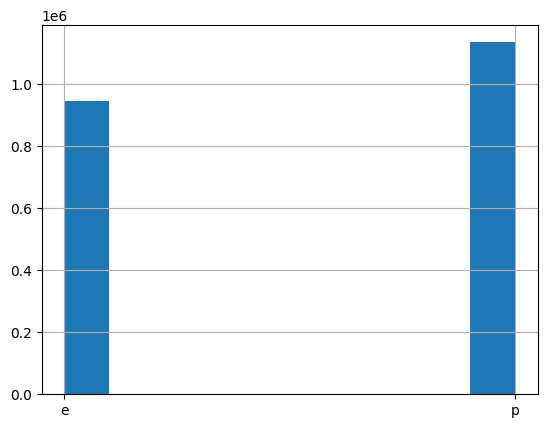

In [120]:
df_sub['class'].hist()

<p style="font-family: 'Amiri', serif; font-size: 3rem; color: black; text-align: center; margin: 0; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3); background-color: grey; padding: 10px; border-radius: 10px; border: 7px solid cyan; width: 95%;">
  <span style="font-weight: bold; color: blue; animation: pulse 2s infinite;">💾Save </span>
  <span style="font-style: italic; color: #2ca02c; animation: pulse 2s infinite;"> the model 💾</span>
</p>

In [121]:
import joblib
from datetime import datetime


# Obtén la fecha y hora actual en formato adecuado (sin segundos)
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Crea el nombre del archivo con la fecha y hora
filename = f'xgb_model_{timestamp}.joblib'

# Guarda el modelo en un archivo con el nombre generado
joblib.dump(XGB, filename)

print(f'Modelo guardado como {filename}')


Modelo guardado como xgb_model_20240824_1820.joblib
